Cluster Analysis for Pairs Trading

1. Data Preparation
2. k-Means Clustering
3. Hierarchical Clustering
4. Affinity Propagation Clustering
5. Model Performance
6. Pairs Extraction

Data Extraction

In [75]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving cluster_models.json to cluster_models.json
Saving etfs.csv to etfs (1).csv


In [3]:
import io
data = pd.read_csv(io.BytesIO(uploaded['etfs.csv']),index_col="Date")
data

,ACWI,DIA,DVY,EEM,EFA,EFG,EFV,EWJ,FTCS,FVD,...,VYM,XBI,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,,
1/4/10,32.882568,78.916664,28.334114,32.683086,38.690956,44.652161,31.561934,32.557251,17.028843,9.895590,...,25.738609,17.594503,38.477596,9.432528,21.969957,19.192505,18.808447,19.625519,25.311979,25.304152
1/5/10,33.156841,78.789673,28.213045,32.920300,38.725052,44.604874,31.763165,32.752796,17.053526,9.866245,...,25.738609,17.662304,38.791641,9.605900,22.047543,19.167759,18.815502,19.391869,25.063744,25.396935
1/6/10,33.149231,78.841949,28.251280,32.989162,38.888733,44.691563,31.854626,32.883148,17.045298,9.844242,...,25.792103,17.897968,39.256180,9.625158,22.094080,18.953312,18.801395,19.505537,25.319988,25.430672
1/7/10,32.989239,79.125748,28.283133,32.797859,38.738697,44.589119,31.726572,32.589836,17.045298,9.873583,...,25.838898,17.897968,39.197281,9.830635,22.334578,18.879082,18.801395,19.417133,25.408073,25.641537
1/8/10,33.194935,79.252777,28.327734,33.058048,39.045601,44.927982,32.061958,32.980915,17.037071,9.902926,...,25.885693,17.978689,39.452450,9.772840,22.691429,19.002806,18.737925,19.398188,25.448111,25.633104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/23/22,85.059998,331.648895,120.959999,37.799999,65.889999,84.010002,46.009998,54.770000,75.199997,40.070000,...,108.290001,80.879997,87.059998,33.950001,98.389999,124.599998,75.180000,70.910004,136.100006,129.429993
12/27/22,85.029999,332.088531,121.750000,38.360001,65.989998,84.029999,46.150002,54.520000,75.139999,40.189999,...,108.610001,78.540001,87.989998,33.939999,98.690002,123.419998,75.540001,71.349998,135.750000,127.330002
12/28/22,83.930000,328.291748,120.139999,37.799999,65.290001,83.220001,45.619999,53.869999,74.410004,39.720001,...,107.449997,78.830002,86.019997,33.820000,97.400002,121.430000,74.599998,70.669998,134.869995,126.260002


Check for missing values

In [43]:
data.isnull().values.any()

False

<AxesSubplot:>

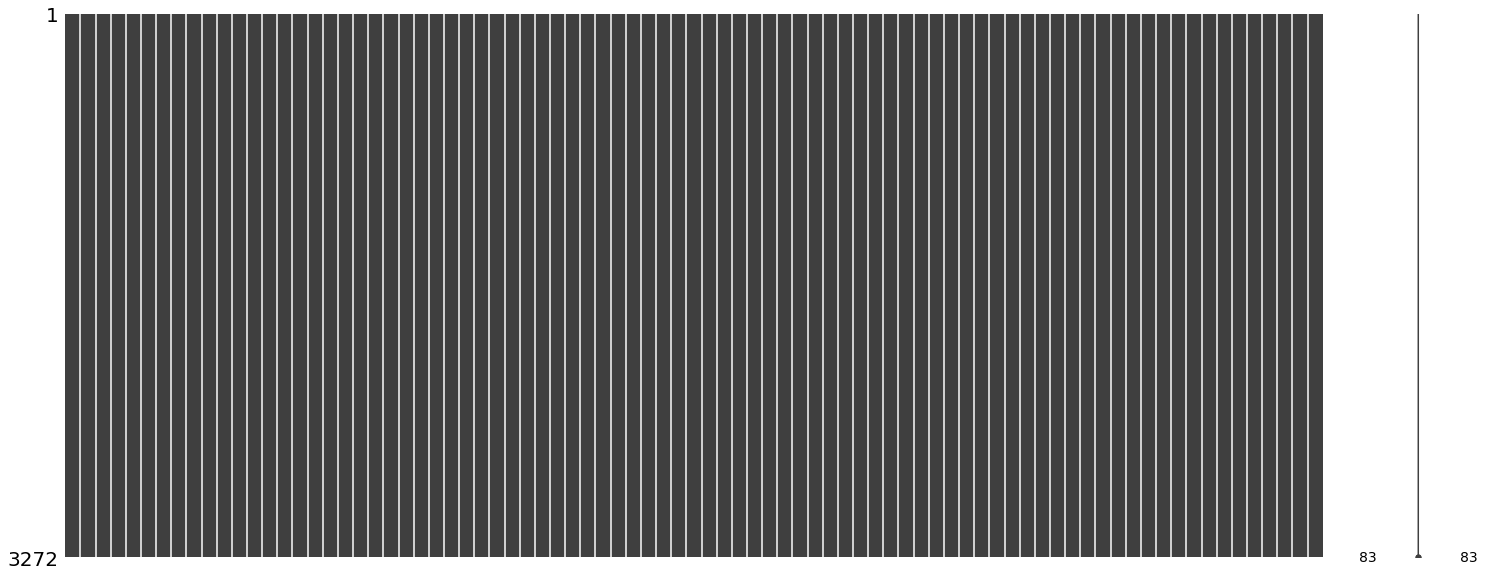

In [44]:
# !pip install missingno
import missingno
missingno.matrix(data)

In [45]:
print('Data Shape before cleaning =', data.shape)

missing_percentage = data.isnull().mean().sort_values(ascending=False)
missing_percentage.head(10)
dropped_list = sorted(list(missing_percentage[missing_percentage > 0.2].index))
data.drop(labels=dropped_list, axis=1, inplace=True)

print('Data Shape after cleaning =', data.shape)

Data Shape before cleaning = (3272, 83)
Data Shape after cleaning = (3272, 83)


In [46]:
data = data.fillna(method='ffill')

Create DF for mean returns and volatility

In [47]:
import numpy as np

#Calculate returns and create a data frame
returns = data.pct_change().mean()*266
returns = pd.DataFrame(returns)
returns.columns = ['returns']

#Calculate the volatility
returns['volatility'] = data.pct_change().std()*np.sqrt(266)

data = returns
data.head()

,returns,volatility
ACWI,0.094282,0.184784
DIA,0.132265,0.176441
DVY,0.133228,0.175299
EEM,0.038397,0.229122
EFA,0.062505,0.197035


Scale the data to normalize it between 0 and 1

In [48]:
from sklearn.preprocessing import StandardScaler

#Prepare the scaler
scale = StandardScaler().fit(data)

#Fit the scaler
scaled_data = pd.DataFrame(scale.fit_transform(data),columns = data.columns, index = data.index)
X = scaled_data
X.head()

,returns,volatility
ACWI,-0.919315,-0.586881
DIA,0.232108,-0.813165
DVY,0.261294,-0.844140
EEM,-2.613444,0.615686
EFA,-1.882630,-0.254590


K-Means Clustering

In [49]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

Find optimal number of clusters using elbow method

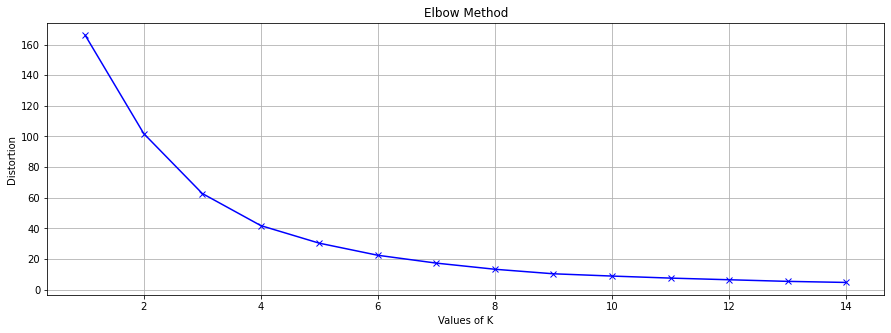

In [50]:
K = range(1,15)
distortions = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    # inertia[k] = kmeanModel.inertia_
    
#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [51]:
!pip install kneed
from kneed import KneeLocator
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
kl.elbow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


4

Find optimal number of clusters using silhouette method

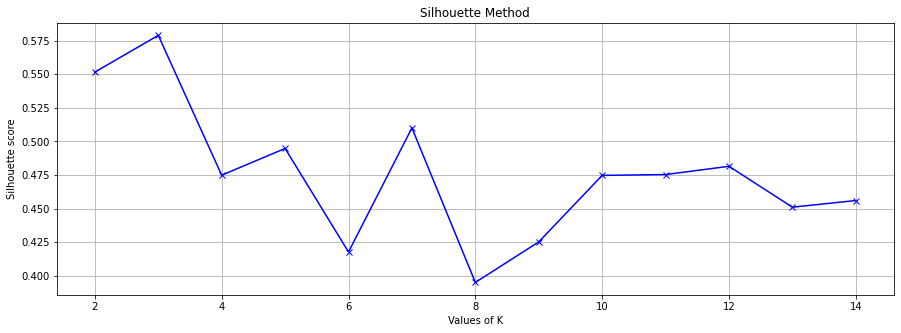

Suggested number of clusters:  2


In [52]:
from sklearn.metrics import silhouette_score

K = range(2,15)
silhouettes = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(X)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, silhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

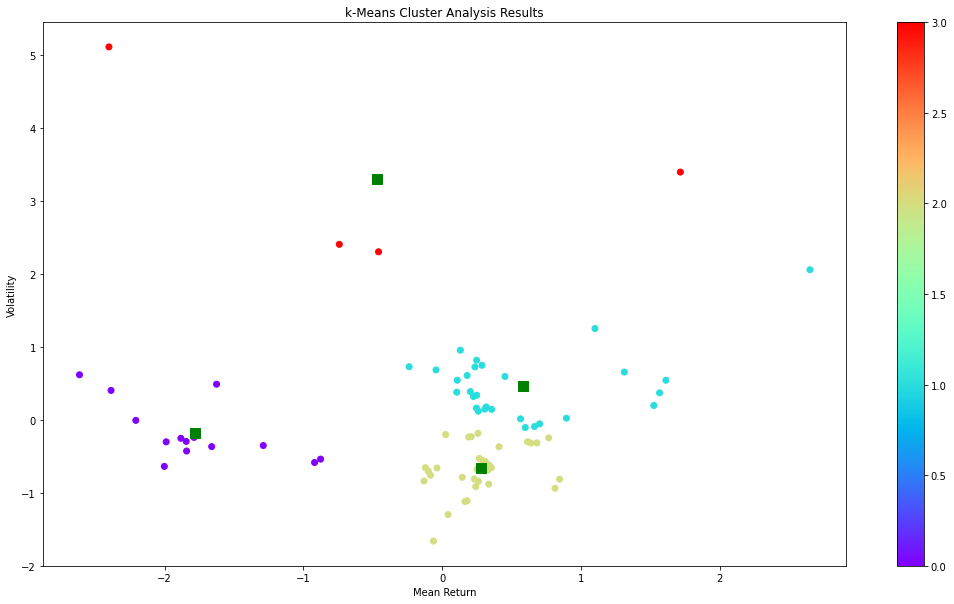

In [53]:
c = 4
#Fit the model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(X)

#Plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label = X.index)
ax.set_title('k-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=10)
plt.show()

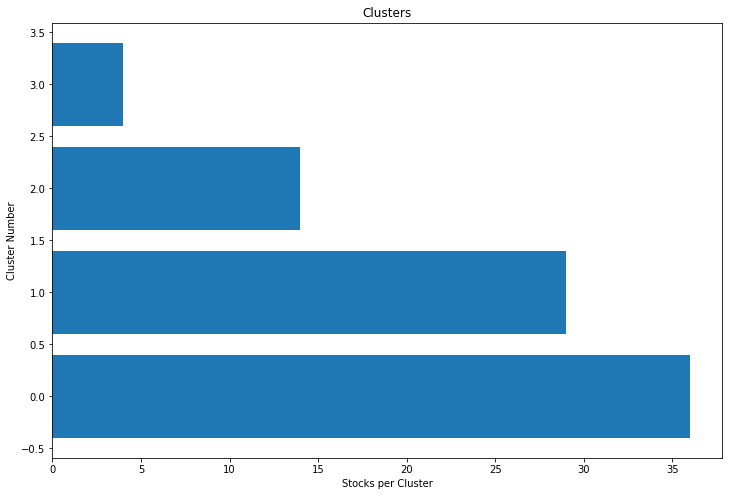

In [54]:
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()

We see that with K-means 4 clusters are optimal and we get ETFs distributed in clusters as shown above

---

Hierarchical Clustering

In [55]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

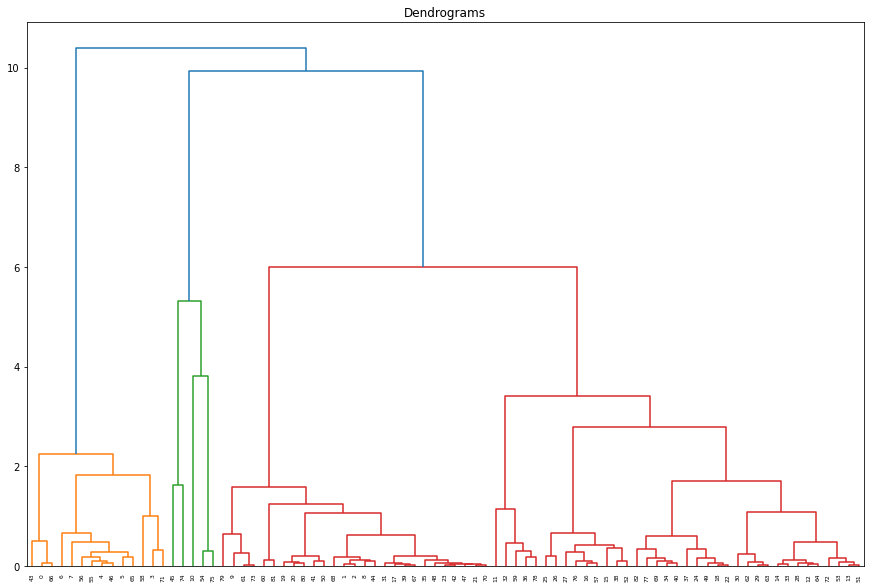

In [56]:
plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))

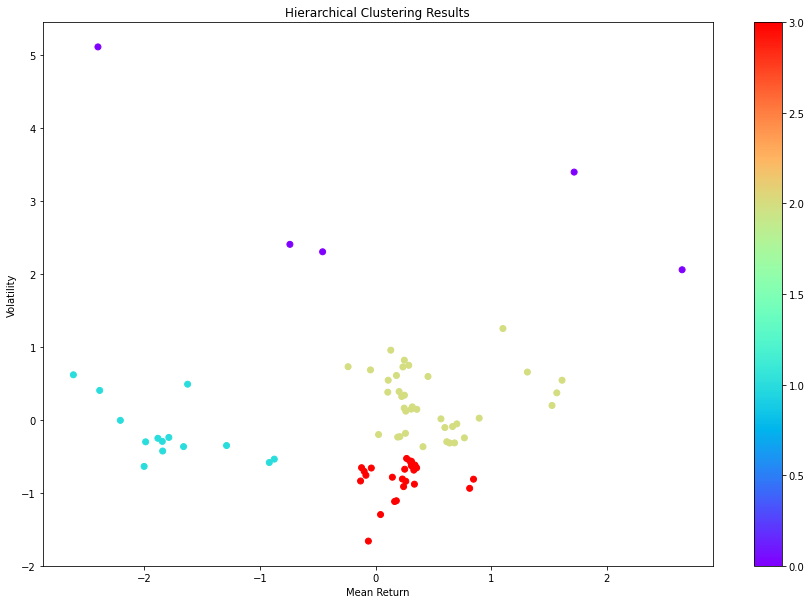

In [57]:
#Fit the model
clusters = 4
hc = AgglomerativeClustering(n_clusters= clusters, affinity='euclidean', linkage='ward')
labels = hc.fit_predict(X)

#Plot the results
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Hierarchical Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

We see that with the Hierarchical method, 4 clusters are optimal and we get ETFs distributed in clusters as shown above

---

Affinity Propagation Clustering

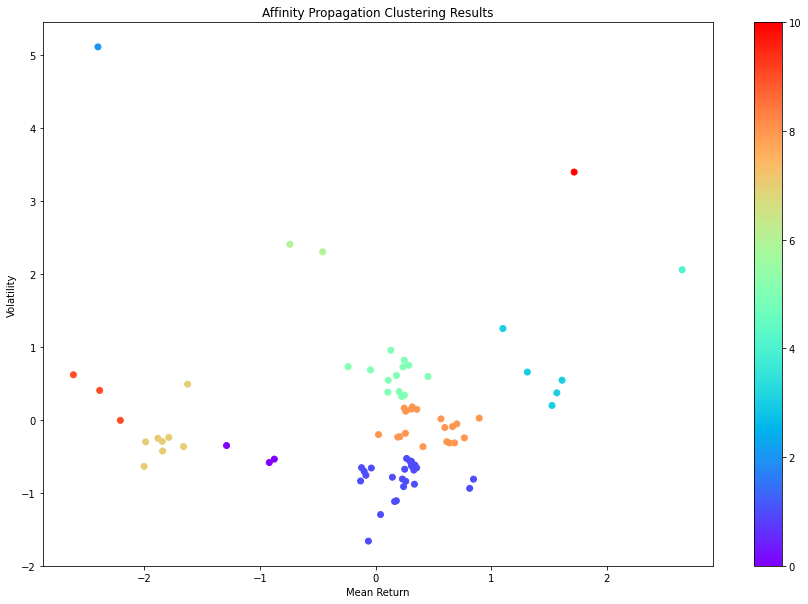

In [58]:
from sklearn.cluster import AffinityPropagation

#Fit the model
ap = AffinityPropagation()
ap.fit(X)
labels1 = ap.predict(X)

#Plot the results
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels1, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

The number of clusters is: 11
[ 0  1 10 32 45 52 54 55 69 71 74]


<Figure size 432x288 with 0 Axes>

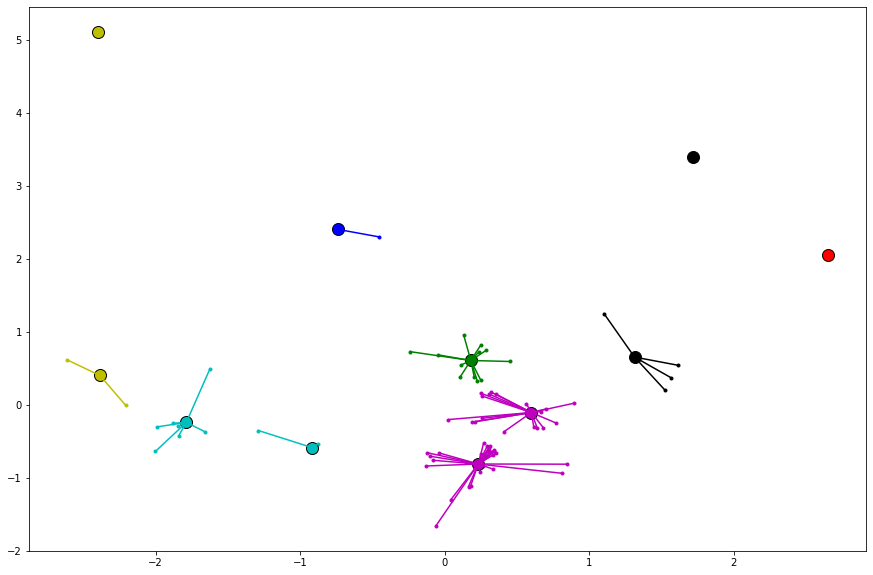

In [59]:
from itertools import cycle

cci = ap.cluster_centers_indices_
labels2 = ap.labels_

clusters = len(cci)
print('The number of clusters is:',clusters)
print(cci)

#Plot the results
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels2 == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

We see that with the Affinity Propagation method, 4 clusters are optimal and we get ETFs distributed in clusters as shown above

---

Compare Silhouette Scores of 3 Clustering Methods

In [60]:
print("k-Means Clustering", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("Hierarchical Clustering", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("Affinity Propagation Clustering", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

k-Means Clustering 0.47480977918806877
Hierarchical Clustering 0.4496231072500137
Affinity Propagation Clustering 0.4721444176771687


----

Now, we eliminate outlier clusters

In [61]:
X['cluster'] = labels2
X

,returns,volatility,cluster
ACWI,-0.919315,-0.586881,0
DIA,0.232108,-0.813165,1
DVY,0.261294,-0.844140,1
EEM,-2.613444,0.615686,9
EFA,-1.882630,-0.254590,7
...,...,...,...
XLK,1.567266,0.368260,3
XLP,-0.062231,-1.664170,1
XLU,-0.121234,-0.657923,1
XLV,0.813562,-0.940837,1


In [62]:
useful_clusters = list(X.groupby(by='cluster', ).count().sort_values('returns',ascending=False).head(3).index)
useful_clusters

[1, 8, 5]

In [63]:
X_useful = X[X['cluster'].isin(useful_clusters)]
X_useful

,returns,volatility,cluster
DIA,0.232108,-0.813165,1
DVY,0.261294,-0.844140,1
FTCS,0.335833,-0.883888,1
FVD,0.042990,-1.300328,1
IJH,0.308345,0.144892,8
IJJ,0.249370,0.336242,5
IJK,0.261164,0.116986,8
IJR,0.453155,0.592410,5
IJS,0.287146,0.746019,5
ITOT,0.309418,-0.594961,1


In [64]:
X_useful.sort_values('cluster')

,returns,volatility,cluster
DIA,0.232108,-0.813165,1
XLV,0.813562,-0.940837,1
SCHV,-0.129984,-0.840398,1
SCHX,0.319507,-0.641583,1
SDY,0.242232,-0.917422,1
SPLG,0.354991,-0.659755,1
SPY,0.330690,-0.691153,1
SPYV,-0.083656,-0.761319,1
VHT,0.846887,-0.815450,1
VIG,0.164424,-1.121421,1


In [65]:
clustered_etfs = []

for x in X_useful['cluster'].unique():

    clustered_etfs.append(list(X_useful[X_useful['cluster'] == x].index))

In [66]:
clustered_etfs

[['DIA',
  'DVY',
  'FTCS',
  'FVD',
  'ITOT',
  'IUSV',
  'IVE',
  'IVV',
  'IWB',
  'IWV',
  'OEF',
  'SCHB',
  'SCHV',
  'SCHX',
  'SDY',
  'SPLG',
  'SPY',
  'SPYV',
  'VHT',
  'VIG',
  'VTI',
  'VTV',
  'VV',
  'VYM',
  'XLP',
  'XLU',
  'XLV'],
 ['IJH',
  'IJK',
  'IUSG',
  'IVW',
  'IWF',
  'IWP',
  'IWR',
  'IWS',
  'MDY',
  'MGK',
  'RSP',
  'SCHG',
  'SPYG',
  'VO',
  'VOE',
  'VOT',
  'VUG',
  'XLI',
  'XLY'],
 ['IJJ',
  'IJR',
  'IJS',
  'IWM',
  'IWN',
  'IWO',
  'SCHA',
  'VB',
  'VBK',
  'VBR',
  'VFH',
  'VXF',
  'XLF']]

In [103]:
data2 = pd.read_csv('etfs.csv',index_col="Date")
df = data2[['DIA','DVY']].tail(253)
df['DIA_DVY'] = df.apply(lambda x: x['DIA'] - x['DVY'], axis=1)
df['DIA_DVY'].mean()

206.14169372173913

Date
12/30/21    238.443100
12/31/21    237.553429
1/3/22      239.315269
1/4/22      239.779732
1/5/22      236.317200
               ...    
12/23/22    210.688896
12/27/22    210.338531
12/28/22    208.151749
12/29/22    210.398781
12/30/22    210.449410
Name: DIA_DVY, Length: 253, dtype: float64


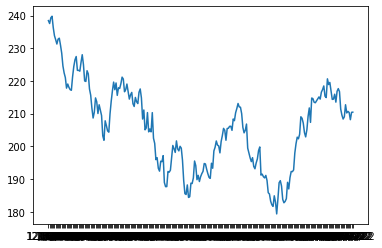

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
plt.plot(df.index, df.DIA_DVY)
series_one = pd.Series(df['DIA_DVY'])
print(series_one)

In [7]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a univariate sequence
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
def modeling(raw_seq):
  # choose a number of time steps
  n_steps = 5
  # split into samples
  X, y = split_sequence(raw_seq, n_steps)
  # reshape from [samples, timesteps] into [samples, timesteps, features]
  n_features = 1
  X = X.reshape((X.shape[0], X.shape[1], n_features))
  # define model
  model = Sequential()
  model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
  model.add(LSTM(50, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  model.fit(X, y, epochs=200, verbose=0)

modeling(series_one)

In [118]:
#for 7 days prediction
import pandas as pd
import matplotlib.pyplot as plt

df1 = df['DIA_DVY']
df['DIA_DVY_5'] = df1.iloc[:].rolling(window=5).mean()
series_5 = pd.Series(df['DIA_DVY_5'])
df['DIA_DVY_signal1'] = np.where(df['DIA_DVY_5'] < df['DIA_DVY'], 'B', 'A')

df['DIA_DVY_pct'] = df.apply(lambda x: x['DIA'] - x['DVY'], axis=1)
df.DIA_DVY_pct = df.DIA_DVY_pct.pct_change(periods=1)
df['DIA_DVY_signal2'] = np.select([(df['DIA_DVY_pct']  > 0.003), (df['DIA_DVY_pct']  < -0.003), (df['DIA_DVY_pct']  < 0.003) & (df['DIA_DVY_pct']  > -0.003)], ['B', 'A', 'H'])

#trading strategy
df['Trading_signal'] = np.select([(df['DIA_DVY_signal1'] == df['DIA_DVY_signal2']) & (df['DIA_DVY_signal2']=='A'), (df['DIA_DVY_signal1'] == df['DIA_DVY_signal2']) & (df['DIA_DVY_signal2']=='B'), (df['DIA_DVY_signal1'] != df['DIA_DVY_signal2'])],["[Buy,Sell]", "[Sell, Buy]", "[Hold,Hold]"])
df


,DIA,DVY,DIA_DVY,DIA_DVY_5,DIA_DVY_signal1,DIA_DVY_pct,DIA_DVY_signal2,Trading_signal
Date,,,,,,,,
12/30/21,356.760773,118.317673,238.443100,NaN,A,NaN,0,"[Hold,Hold]"
12/31/21,356.025726,118.472298,237.553429,NaN,A,-0.003731,A,"[Buy,Sell]"
1/3/22,358.338409,119.023140,239.315269,NaN,A,0.007417,B,"[Hold,Hold]"
1/4/22,360.484436,120.704704,239.779732,NaN,A,0.001941,H,"[Hold,Hold]"
1/5/22,356.780304,120.463104,236.317200,238.281746,A,-0.014440,A,"[Buy,Sell]"
...,...,...,...,...,...,...,...,...
12/23/22,331.648895,120.959999,210.688896,210.198274,B,0.002277,H,"[Hold,Hold]"
12/27/22,332.088531,121.750000,210.338531,210.595430,A,-0.001663,H,"[Hold,Hold]"
12/28/22,328.291748,120.139999,208.151749,210.421400,A,-0.010396,A,"[Buy,Sell]"


In [18]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a univariate sequence
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
def modeling(raw_seq, steps):
  # choose a number of time steps
  n_steps = steps
  # split into samples
  X, y = split_sequence(raw_seq, n_steps)
  # reshape from [samples, timesteps] into [samples, timesteps, features]
  n_features = 1
  X = X.reshape((X.shape[0], X.shape[1], n_features))
  # define model
  model = Sequential()
  model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
  model.add(LSTM(50, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  model.fit(X, y, epochs=200, verbose=0)

modeling(series_5,3)

In [110]:
# differentaiting the A-B
data2 = pd.read_csv('etfs.csv',index_col="Date")
df = data2[['DIA','DVY']].tail(253)
df['DIA_DVY'] = df.apply(lambda x: x['DIA'] - x['DVY'], axis=1)
df2 = df.pct_change()
df3 = df2['DIA_DVY']
df2

,DIA,DVY,DIA_DVY
Date,,,
12/30/21,NaN,NaN,NaN
12/31/21,-0.002060,0.001307,-0.003731
1/3/22,0.006496,0.004650,0.007417
1/4/22,0.005989,0.014128,0.001941
1/5/22,-0.010275,-0.002002,-0.014440
...,...,...,...
12/23/22,0.005057,0.009936,0.002277
12/27/22,0.001326,0.006531,-0.001663
12/28/22,-0.011433,-0.013224,-0.010396


In [35]:
df3.std()

0.013707512238740225

In [39]:
series_change = pd.Series(df2['DIA_DVY'])
print(series_change)

Date
12/30/21         NaN
12/31/21   -0.003731
1/3/22      0.007417
1/4/22      0.001941
1/5/22     -0.014440
              ...   
12/23/22    0.002277
12/27/22   -0.001663
12/28/22   -0.010396
12/29/22    0.010795
12/30/22    0.000241
Name: DIA_DVY, Length: 253, dtype: float64


In [40]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a univariate sequence
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
def modeling(raw_seq,steps):
  # choose a number of time steps
  n_steps = steps
  # split into samples
  X, y = split_sequence(raw_seq, n_steps)
  # reshape from [samples, timesteps] into [samples, timesteps, features]
  n_features = 1
  X = X.reshape((X.shape[0], X.shape[1], n_features))
  # define model
  model = Sequential()
  model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
  model.add(LSTM(50, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  model.fit(X, y, epochs=200, verbose=0)


In [135]:
import json
  
# Opening JSON file
f = open('cluster_models.json')
  
# returns JSON object as 
# a dictionary
clusters_all = json.load(f)

km_clusters_all = clusters_all['k-means']
km_clusters_all
for i in km_clusters_all:
  for j in i:
    a = j[0]
    b = j[1]
    df = data2[[f'{a}',f'{b}']].tail(253)
    df['a_b'] = df.apply(lambda x: x[f'{a}'] - x[f'{b}'], axis=1)
    
    df1 = df['a_b']
    df['a_b_5'] = df1.iloc[:].rolling(window=5).mean()
    series_5 = pd.Series(df['a_b_5'])
    df['a_b_signal1'] = np.where(df['a_b_5'] < df['a_b'], 'B', 'A')

    df['a_b_pct'] = df.apply(lambda x: x[f'{a}'] - x[f'{b}'], axis=1)
    df.a_b_pct = df.a_b_pct.pct_change(periods=1)
    df['a_b_signal2'] = np.select([(df['a_b_pct']  > 0.003), (df['a_b_pct']  < -0.003), (df['a_b_pct']  < 0.003) & (df['a_b_pct']  > -0.003)], ['B', 'A', 'H'])

    #trading strategy
    df['Trading_signal'] = np.select([(df['a_b_signal1'] == df['a_b_signal2']) & (df['a_b_signal2']=='A'), (df['a_b_signal1'] == df['a_b_signal2']) & (df['a_b_signal2']=='B'), (df['a_b_signal1'] != df['a_b_signal2'])],["[Buy,Sell]", "[Sell, Buy]", "[Hold,Hold]"])
    
    #forecasting
    series_change = pd.Series(df2['a_b_pct'])
    modeling(series_change,5)

    series_5 = pd.Series(df2['a_b_5'])
    modeling(series_5,3)
    
    series_diff = pd.Series(df2['a_b'])
    modeling(series_diff,5)



In [136]:
km_clusters_all = clusters_all['k-means']
km_clusters_all

[[['ACWI', 'EFA'],
  ['ACWI', 'EFG'],
  ['ACWI', 'EFV'],
  ['ACWI', 'EWJ'],
  ['ACWI', 'SCZ'],
  ['ACWI', 'SPDW'],
  ['ACWI', 'VEA'],
  ['ACWI', 'VEU'],
  ['ACWI', 'VGK'],
  ['ACWI', 'VSS'],
  ['ACWI', 'VT'],
  ['EFA', 'EFG'],
  ['EFA', 'EFV'],
  ['EFA', 'EWJ'],
  ['EFA', 'SCZ'],
  ['EFA', 'SPDW'],
  ['EFA', 'VEA'],
  ['EFA', 'VEU'],
  ['EFA', 'VGK'],
  ['EFA', 'VSS'],
  ['EFA', 'VT'],
  ['EFG', 'EFV'],
  ['EFG', 'EWJ'],
  ['EFG', 'SCZ'],
  ['EFG', 'SPDW'],
  ['EFG', 'VEA'],
  ['EFG', 'VEU'],
  ['EFG', 'VGK'],
  ['EFG', 'VSS'],
  ['EFG', 'VT'],
  ['EFV', 'EWJ'],
  ['EFV', 'SCZ'],
  ['EFV', 'SPDW'],
  ['EFV', 'VEA'],
  ['EFV', 'VEU'],
  ['EFV', 'VGK'],
  ['EFV', 'VSS'],
  ['EFV', 'VT'],
  ['EWJ', 'SCZ'],
  ['EWJ', 'SPDW'],
  ['EWJ', 'VEA'],
  ['EWJ', 'VEU'],
  ['EWJ', 'VGK'],
  ['EWJ', 'VSS'],
  ['EWJ', 'VT'],
  ['SCZ', 'SPDW'],
  ['SCZ', 'VEA'],
  ['SCZ', 'VEU'],
  ['SCZ', 'VGK'],
  ['SCZ', 'VSS'],
  ['SCZ', 'VT'],
  ['SPDW', 'VEA'],
  ['SPDW', 'VEU'],
  ['SPDW', 'VGK'],
  ['SPDW', 'VS

In [100]:
for i in km_clusters_all:
  for j in i:
    print(j[0])
len(km_clusters_all)

ACWI
ACWI
ACWI
ACWI
ACWI
ACWI
ACWI
ACWI
ACWI
ACWI
ACWI
EFA
EFA
EFA
EFA
EFA
EFA
EFA
EFA
EFA
EFA
EFG
EFG
EFG
EFG
EFG
EFG
EFG
EFG
EFG
EFV
EFV
EFV
EFV
EFV
EFV
EFV
EFV
EWJ
EWJ
EWJ
EWJ
EWJ
EWJ
EWJ
SCZ
SCZ
SCZ
SCZ
SCZ
SCZ
SPDW
SPDW
SPDW
SPDW
SPDW
VEA
VEA
VEA
VEA
VEU
VEU
VEU
VGK
VGK
VSS
IUSV
IUSV
IUSV
IUSV
IUSV
IUSV
IUSV
IVE
IVE
IVE
IVE
IVE
IVE
IWM
IWM
IWM
IWM
IWM
IWN
IWN
IWN
IWN
SCHV
SCHV
SCHV
SPYV
SPYV
XLP


2